This core describes how I selected and trained models to classify the *SETI* dataset.

In order to use the *SETI* dataset correctly and to create dataloaders, I used this [kernel](https://www.kaggle.com/ayuraj/train-tensorflow-efficientnet-kfold-w-b) from **Ayush Thakur**.

This kernel consists of the following parts:
- analysing the imbalance of the dataset,
- loading and pre-processing the data,
- comparing several models with 10% of the dataset,
- setting the hyperparameters of the best model,
- use of the best model with the whole dataset,
- predictions with the best models, as well as with a vote of all models,
- results based on Kaggle's analysis of predictions.

# Download EfficientNet model

In [3]:
!pip install -q efficientnet

# Import libraries

In [4]:
import os
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import efficientnet.tfkeras as efn
import kerastuner as kt
import tensorflow_addons as tfa

# Set the configuration of this project

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

CONFIGURATION = dict (
    seed = 0,
    nbr_classes = 1,
    nbr_folds = 5,
    img_width = 250,
    img_height = 250,
    batch_size = 16,
    epochs = 1000,
    learning_rate = 1e-4,
    model_used = "efficientnet",
    alpha = 0.2
)

Check if a GPU is available

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:    
    # Currently, memory growth needs to be the same across GPUs
    
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Use the csv file to analyse the imbalance of the dataset

In [6]:
df = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
df['img_path'] = df['id'].apply(lambda x: f'../input/seti-breakthrough-listen/train/{x[0]}/{x}.npy')
df.head()

,id,target,img_path
0,00034abb3629,0,../input/seti-breakthrough-listen/train/0/0003...
1,0004300a0b9b,0,../input/seti-breakthrough-listen/train/0/0004...
2,000453852fda,0,../input/seti-breakthrough-listen/train/0/0004...
3,00047dfc96a9,0,../input/seti-breakthrough-listen/train/0/0004...
4,0004be0baf70,0,../input/seti-breakthrough-listen/train/0/0004...


In [12]:
# Estimate class weights based on the imbalance of the data set

neg = df.target.value_counts()[0]
pos = df.target.value_counts()[1]

print("neg = {}\npos = {}\n".format(neg, pos))

# weigts to correct imbalance:
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1))

# Initial bias:

initial_bias = np.log([pos/neg])
print("initial_bias: {:.2f}".format(initial_bias[0]))

neg = 45471
pos = 4694

Weight for class 0: 0.55
Weight for class 1: 5.34

initial_bias: -2.27


Split the dataset into n folds

In [13]:
kfold = StratifiedKFold(n_splits=CONFIGURATION["nbr_folds"], shuffle=True, random_state=CONFIGURATION["seed"])

for n, (train_index, val_index) in enumerate(kfold.split(df, df['target'])):
    df.loc[val_index, 'fold'] = int(n)

df['fold'] = df['fold'].astype(int)

df.groupby(['fold', 'target']).size()

fold  target
0     0         9095
      1          938
1     0         9094
      1          939
2     0         9094
      1          939
3     0         9094
      1          939
4     0         9094
      1          939
dtype: int64

# Data loading and pre-processing functions

In [ ]:
def load_npy(path):
    
    # load npy data
    data = np.load(path.numpy()).astype(np.float32)
    
    # stack -> we only keep the on-target observations
    data = np.dstack((data[0], data[2], data[4]))
        
    return data


@tf.function
def load_resize_data_augmentation(df_dict):
    # Load image
    [image,] = tf.py_function(load_npy, [df_dict['img_path']], [tf.float32])
    image.set_shape((273, 256, 3))
    
    # Resize image
    image = tf.image.resize(image, (CONFIGURATION['img_height'], CONFIGURATION['img_width']))
    
    
    # Data augmentation
    # image = tf.image.random_brightness(image, 0.2, seed=CONFIGURATION["seed"])
    image = tf.image.random_hue(image, 0.2, seed=CONFIGURATION["seed"])
    # image = tf.image.random_flip_left_right(image, seed=CONFIGURATION["seed"])
    image = tf.image.random_flip_up_down(image, seed=CONFIGURATION["seed"])
    
    
    if CONFIGURATION["model_used"] == "Xception":
        image = tf.keras.applications.xception.preprocess_input(image)
    
    # Parse label
    label = df_dict['target']
    label = tf.cast(label, tf.float32)
    
    return image, label

@tf.function
def load_resize_spec(df_dict):
    # Load image
    [image,] = tf.py_function(load_npy, [df_dict['img_path']], [tf.float32])
    image.set_shape((273, 256, 3))
    
    # Resize image
    image = tf.image.resize(image, (CONFIGURATION['img_height'], CONFIGURATION['img_width']))
    
    if CONFIGURATION["model_used"] == "Xception":
        image = tf.keras.applications.xception.preprocess_input(image)
    
    # Parse label
    label = df_dict['target']
    label = tf.cast(label, tf.float32)
    
    return image, label

In [ ]:
# Dataloaders for the train set and the validation set

AUTOTUNE = tf.data.AUTOTUNE

def get_dataloaders(train_df, valid_df):
    trainloader = tf.data.Dataset.from_tensor_slices(dict(train_df))
    validloader = tf.data.Dataset.from_tensor_slices(dict(valid_df))

    trainloader = (
        trainloader
        .shuffle(1024)
        .map(load_resize_data_augmentation, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )

    validloader = (
        validloader
        .map(load_resize_spec, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )
    
    return trainloader, validloader

Mixup function: [tutorial](https://keras.io/examples/vision/mixup/)

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = l

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
# Dataloaders for the train set with mixup
# and the validation set whithout mixup

AUTOTUNE = tf.data.AUTOTUNE
alpha_ = CONFIGURATION["alpha"]

def get_dataloader_train(train_df):
        
    trainloader = tf.data.Dataset.from_tensor_slices(dict(train_df))    

    trainloader_1 = (
        trainloader
        .shuffle(1024)
        .map(load_resize_data_augmentation, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )
    
    trainloader_2 = (
        trainloader
        .shuffle(1024)
        .map(load_resize_data_augmentation, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )
    
    train_ds = tf.data.Dataset.zip((trainloader_1, trainloader_2))
    
    train_ds_mu = train_ds.map(
        lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=alpha_),
        num_parallel_calls=AUTOTUNE
    ).prefetch(AUTOTUNE)
    
    return train_ds_mu
    
def get_dataloader_val(valid_df):
    validloader = tf.data.Dataset.from_tensor_slices(dict(valid_df))
    
    validloader = (
        validloader
        .map(load_resize_spec, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )
    
    return validloader

# Comparing several models with 10% of the dataset

In [ ]:
def make_model(base_model, layers_trainable=False, output_bias=None):
    
    # Transfer Learning: base_model
    for layer in base_model.layers:
        layer.trainable = layers_trainable

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
            
    if output_bias != None:
        output_ = tf.keras.layers.Dense(
            CONFIGURATION['nbr_classes'],
            activation="sigmoid",
            bias_initializer=tf.keras.initializers.Constant(output_bias)        
        )(x)
    else:
        output_ = tf.keras.layers.Dense(CONFIGURATION['nbr_classes'], activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=base_model.input, outputs=output_)
    
    return model

In [ ]:
def model_to_compare(model_name, base_model):
    
    CONFIGURATION["model_used"] = model_name
    
    print("Model trained: " + model_name + "\n")
    
    #----------------------#
    
    # we are using only 1 fold in order to train and to compare these models
    # here, it will be the first fold (number 0)

    # Preparing the train and validation df

    train_df = df.loc[df.fold != 0].reset_index(drop=True)
    valid_df = df.loc[df.fold == 0].reset_index(drop=True)

    # We will use 10 % of the whole dataset
    train_subset, _ = train_test_split(train_df, stratify=train_df.target, random_state=0, train_size=0.1)
    valid_subset, _ = train_test_split(valid_df, stratify=valid_df.target, random_state=0, train_size=0.1)
    train_subset = train_subset.reset_index(drop=True)
    valid_subset = valid_subset.reset_index(drop=True)

    # Preparing the dataloaders
    trainloader, validloader = get_dataloaders(train_subset, valid_subset)
    
    #----------------------#
    
    # Creating the model
    # tf.keras.backend.clear_session()
    model = make_model(
        base_model,
        layers_trainable=True,
        output_bias=initial_bias
    )
    
    #----------------------#
    
    # Compiling the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr=CONFIGURATION["learning_rate"]),
        loss="binary_crossentropy",
        metrics=tf.keras.metrics.AUC(curve='ROC')
    )
    
    #----------------------#
    
    # Training the model
    model.fit(
        trainloader,
        epochs=CONFIGURATION["epochs"],
        batch_size=CONFIGURATION["batch_size"],
        validation_data=validloader,
        class_weight=class_weights,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
    )
    
    print("\n******************\n")
    
    #----------------------#
    
    # Metrics
    loss, auc = model.evaluate(validloader)
    
    #----------------------#
        
    # cleaning memory
    del model
    _ = gc.collect()
    
    return loss, auc

In [14]:
# Comparing models

model_name_list = ["Xception", "EfficientNetB0", "EfficientNetB4", "EfficientNetB7"]

In [ ]:
# Xception

CONFIGURATION["batch_size"] = 64

loss_xception, auc_xception = model_to_compare(
    "Xception",
    tf.keras.applications.Xception(weights="imagenet",include_top=False)
)

In [ ]:
# EfficientNetB0

CONFIGURATION["batch_size"] = 64

loss_efnb0, auc_efnb0 = model_to_compare(
    "EfficientNetB0",
    efn.EfficientNetB0(
        input_shape=(CONFIGURATION["img_width"], CONFIGURATION["img_height"], 3),
        weights='imagenet',
        include_top=False
    )
)

In [ ]:
# EfficientNetB4

CONFIGURATION["batch_size"] = 16

loss_efnb4, auc_efnb4 = model_to_compare(
    "EfficientNetB4",
    efn.EfficientNetB4(
        input_shape=(CONFIGURATION["img_width"], CONFIGURATION["img_height"], 3),
        weights='imagenet',
        include_top=False
    )
)

In [ ]:
# EfficientNetB7

CONFIGURATION["batch_size"] = 8

loss_efnb7, auc_efnb7 = model_to_compare(
    "EfficientNetB7",
    efn.EfficientNetB7(
        input_shape=(CONFIGURATION["img_width"], CONFIGURATION["img_height"], 3),
        weights='imagenet',
        include_top=False
    )
)

In [15]:
'''
loss_models_list = [0.2432, 0.2523, 0.2395, 0.2151]
auc_models_list = [0.7889, 0.8038, 0.8323, 0.8511]
time_per_epoch = [62, 33, 86, 220]
'''

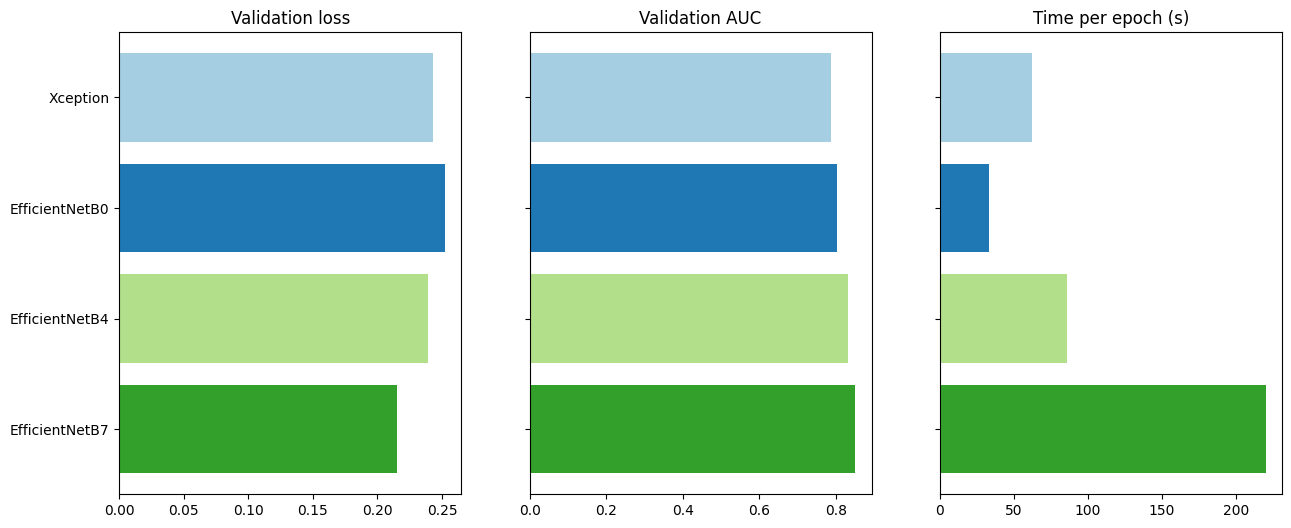

In [16]:
plt.style.use(["default"])

# Visualization

f, axes = plt.subplots(1, 3, figsize=(15, 6))

# Validation loss
axes[0].barh(model_name_list, loss_models_list, color=plt.cm.Paired(np.arange(len(loss_models_list))))
axes[0].set_title("Validation loss")
axes[0].invert_yaxis()

# Validation AUC
axes[1].barh(model_name_list, auc_models_list, color=plt.cm.Paired(np.arange(len(auc_models_list))))
axes[1].set_title("Validation AUC")
axes[1].set_yticklabels([])
axes[1].invert_yaxis()

# Time per epoch
axes[2].barh(model_name_list, time_per_epoch, color=plt.cm.Paired(np.arange(len(time_per_epoch))))
axes[2].set_title("Time per epoch (s)")
axes[2].set_yticklabels([])
axes[2].invert_yaxis()

EfficientNetB7 has the lowest val_loss and the highest val_AUC.

But, for each epoch, it is the slower algorithm to train.

The optimization and the training and the whole dataset will be very slow.

EfficientNetB7 is slower to train than EfficientNetB4 (more than 2 times slower per epoch).
We will not use EfficientNetB7.

Whitout this model, **EfficientNetB4** has the lowest val_loss and the highest val_AUC.
We will use it now, and we will try to improve its generalization.

# Setting the hyperparameters of the best model: EfficientNet B4

In [ ]:
def make_best_model(hp):
    
    base_model = efn.EfficientNetB4(
        input_shape=(CONFIGURATION["img_width"], CONFIGURATION["img_height"], 3),
        weights='imagenet',
        include_top=False
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    #------------------#
    
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)    
    
    x = tf.keras.layers.Dropout(
        rate=hp.Choice(
            "rate_value",
            values=[0.3, 0.4, 0.5],
            
            default=0.4
        )
    )(x)
    
    output_ = tf.keras.layers.Dense(
        CONFIGURATION["nbr_classes"],
        activation="sigmoid",
        bias_initializer=tf.keras.initializers.Constant(initial_bias) 
    )(x)
    
    #------------------#
    
    model = tf.keras.Model(inputs=base_model.input, outputs=output_)
    
    #------------------#
    
    hp_learning_rate = hp.Choice(
        "learning_rate",
        values=[1e-4, 5e-4, 1e-3],
        default=1e-4
    )
    
    '''
    hp_loss = hp.Choice("SigmoidFocalCrossEntropy", "BinaryCrossentropy")
    if hp_loss == "BinaryCrossentropy":
        loss_ = tf.keras.losses.BinaryCrossentropy()
    else:
        loss_ = tfa.losses.SigmoidFocalCrossEntropy()
    '''
    loss_ = tfa.losses.SigmoidFocalCrossEntropy()
    
    # compiling the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=loss_,
        metrics=tf.keras.metrics.AUC(curve='ROC')
    )
    
    return model

In [ ]:
tuner_bayesian = kt.BayesianOptimization(
    make_best_model,
    objective=kt.Objective("val_loss", direction="min"),
    # objective=kt.Objective("auc", direction="max"),
    max_trials=5,
    executions_per_trial=2,
    seed=0,
    overwrite=True
)

In [ ]:
CONFIGURATION["batch_size"] = 16

# Preparing the train and validation df

train_df = df.loc[df.fold != 0].reset_index(drop=True)
valid_df = df.loc[df.fold == 0].reset_index(drop=True)

# We will use 10 % of the whole dataset
train_subset, _ = train_test_split(train_df, stratify=train_df.target, random_state=0, train_size=0.1)
valid_subset, _ = train_test_split(valid_df, stratify=valid_df.target, random_state=0, train_size=0.1)
train_subset = train_subset.reset_index(drop=True)
valid_subset = valid_subset.reset_index(drop=True)

# Preparing the dataloaders
trainloader, validloader = get_dataloaders(train_subset, valid_subset)

#----------------------#

tuner_bayesian.search(
    trainloader,
    epochs=CONFIGURATION["epochs"],
    batch_size=CONFIGURATION["batch_size"],
    validation_data=validloader,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

print("\n******************\n")

#----------------------#

# These are the hyperparameters values:
best_hyperparameters = tuner_bayesian.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(best_hyperparameters.values)

Results of the bayesian optimization:

Trial 5 Complete [00h 25m 41s]

val_loss: 0.02096261829137802

Best val_loss So Far: 0.01797973085194826

Total elapsed time: 01h 47m 29s

******************

Best hyperparameters:

{'rate_value': **0.4**, 'learning_rate': **0.001**}

# Use of the best model with the whole dataset

In [ ]:
def make_best_model_hyp():    
    base_model = efn.EfficientNetB4(
        input_shape=(CONFIGURATION["img_width"], CONFIGURATION["img_height"], 3),
        weights='imagenet',
        include_top=False
    )    
    for layer in base_model.layers:
        layer.trainable = True    
    #------------------#    
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)  
    x = tf.keras.layers.Dropout(rate=0.4)(x)    
    output_ = tf.keras.layers.Dense(
        CONFIGURATION["nbr_classes"],
        activation="sigmoid",
        bias_initializer=tf.keras.initializers.Constant(initial_bias) 
    )(x)
    #------------------#    
    model = tf.keras.Model(inputs=base_model.input, outputs=output_)    
    #------------------#    
    # compiling the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss= tfa.losses.SigmoidFocalCrossEntropy(),
        metrics= tf.keras.metrics.AUC(curve='ROC')
    )    
    return model

In [ ]:
# Empty lists in order to save the results

fold_list = []
loss_list = []
auc_list = []

In [ ]:
def model_cv(model_name_, batch_size, fold, mixup=False):
    model_name = model_name_
    CONFIGURATION["batch_size"] = batch_size

    #----------------------#

    CONFIGURATION["model_used"] = model_name

    print("Model trained: " + model_name + "\n")

    #----------------------#

    print("\n******************\n")

    print("Fold {}:\n".format(fold))
    
    
    # Prepare train and valid df
    train_df = df.loc[df.fold != fold].reset_index(drop=True)
    valid_df = df.loc[df.fold == fold].reset_index(drop=True)
    
    
    # Prepare dataloaders:    
    # whithout mixup
    if mixup == True:
        trainloader, validloader = get_dataloaders(train_df, valid_df)
    # whith mixup
    else:
        trainloader, validloader = get_dataloader_train(train_df), get_dataloader_val(valid_df)
    
    
    # Creating the model
    tf.keras.backend.clear_session()   
    # model = tuner_bayesian.hypermodel.build(best_hyperparameters)
    model = make_best_model_hyp()

    #----------------------#
        
    # Model training
    model.fit(
        trainloader,
        epochs=CONFIGURATION["epochs"],
        batch_size=CONFIGURATION["batch_size"],
        validation_data=validloader,
        class_weight=class_weights,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, min_lr=CONFIGURATION["learning_rate"]),
            tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint", monitor="val_loss", mode="min", save_best_only=True)
        ]
    )
    
    #----------------------#

    # Saving the model

    model_name = 'efficientnetB4_cv'
    model.save(f'{model_name}_{fold}.h5')

    #----------------------#

    # Metrics
    loss, auc = model.evaluate(validloader)

    fold_list.append(fold)
    loss_list.append(loss)
    auc_list.append(auc)

    #----------------------#

    # cleaning memory
    del model, trainloader, validloader, train_df, valid_df
    # _ = gc.collect()

In [ ]:
for fold_ in range(5):
    model_cv(model_name_="EfficientNetB4", batch_size=32, fold=fold_)

In [ ]:
# using mixup augmentation with the fourth fold:
model_cv(model_name_="EfficientNetB4", batch_size=32, fold=3, mixup=True)

In [17]:
# Model: EfficientNetB4

fold_list = ["cv_0", "cv_1", "cv_2", "cv_3", "cv_4", "cv_3_mixup"]
loss_list = [0.0108, 0.0095, 0.0098, 0.0080, 0.0093, 0.0076]
auc_list = [0.9648, 0.9697, 0.9742, 0.9738, 0.9760, 0.9699]

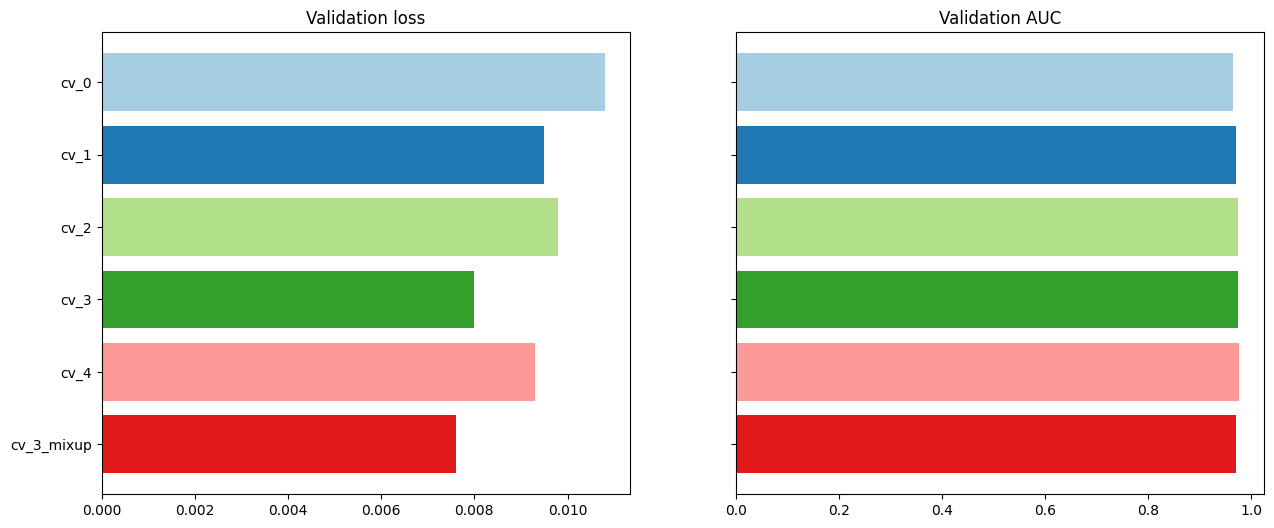

In [18]:
# Comparing the models for each fold

plt.style.use(["default"])

# Visualization

f, axes = plt.subplots(1, 2, figsize=(15, 6))

# Validation loss
axes[0].barh(fold_list, loss_list, color=plt.cm.Paired(np.arange(len(loss_list))))
axes[0].set_title("Validation loss")
axes[0].invert_yaxis()

# Validation AUC
axes[1].barh(fold_list, auc_list, color=plt.cm.Paired(np.arange(len(auc_list))))
axes[1].set_title("Validation AUC")
axes[1].set_yticklabels([])
axes[1].invert_yaxis()

# Predictions with the best models

In [ ]:
# Load test set csv (for image id)

submission = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
submission["img_path"] = submission["id"].apply(lambda x: f'{TEST_PATH}/{x[0]}/{x}.npy')

In [ ]:
# Dataloader for the test set
def get_test_dataloader(test_df):
    testloader = tf.data.Dataset.from_tensor_slices(dict(test_df))

    testloader = (
        testloader
        .map(load_resize_spec, num_parallel_calls=AUTOTUNE)
        .batch(CONFIGURATION['batch_size'])
        .prefetch(AUTOTUNE)
    )
    
    return testloader

In [ ]:
testloader = get_test_dataloader(submission)

# Predictions:

y_pred = []

y_pred.append(model_cv0.predict(testloader, verbose=1))
y_pred.append(model_cv1.predict(testloader, verbose=1))
y_pred.append(model_cv2.predict(testloader, verbose=1))
y_pred.append(model_cv3.predict(testloader, verbose=1))
y_pred.append(model_cv4.predict(testloader, verbose=1))
y_pred.append(model_mixup_cv3.predict(testloader, verbose=1))

# Sumissions for each model:
for y_pred_, name_ in zip(y_pred, fold_list):
    
    submission["target"] = y_pred_
    
    submission.drop(columns=["img_path"]).to_csv("submission_" + name_ + ".csv", index=False)

# Predictions with a vote of all models

In [ ]:
# Mean

submission["target"] = sum(y_pred) / 6

submission.drop(columns=["img_path"]).to_csv('submission_mean.csv', index=False)

In [ ]:
# Harmonic mean
# based on the val_loss of each model

min_ = min(loss_list)

weights = [min_ / loss for loss in loss_list]

submission["target"] = sum([w*y for w, y in zip(weights, y_pred)]) / sum(weights)

submission.drop(columns=["img_path"]).to_csv('submission_h_mean.csv', index=False)

# Results based on Kaggle's analysis of predictions

In [20]:
models = fold_list + ["mean\nno mixup", "h mean\nno mixup", "mean\nwith mixup", "h mean\nwith mixup"]
test_AUC = [0.951, 0.953, 0.952, 0.954, 0.956, 0.942, 0.962, 0.962, 0.962, 0.963]

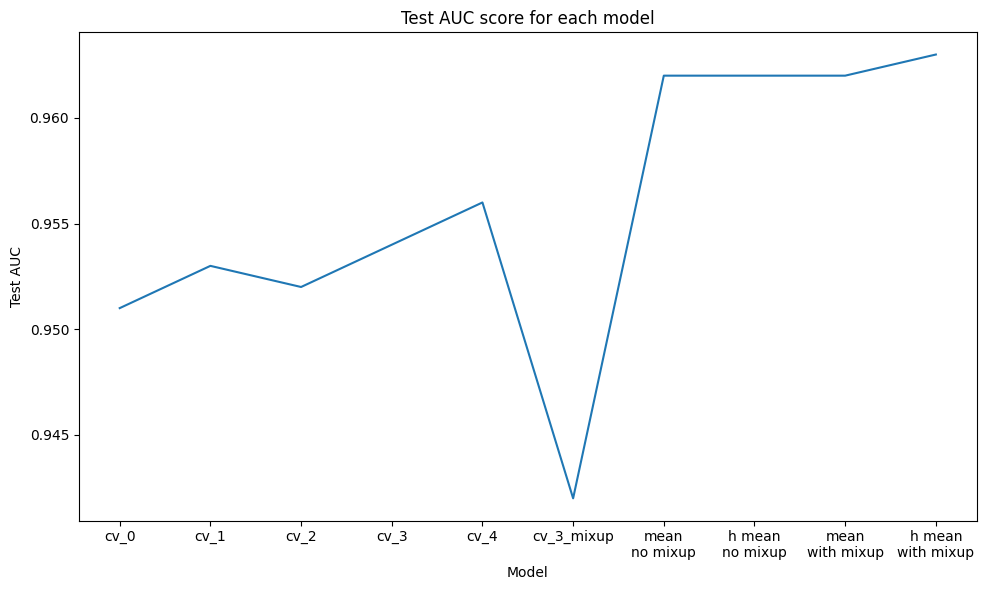

In [28]:
plt.style.use(["default"])

fig = plt.figure(figsize=(10, 6))
ax=fig.add_subplot(111)

plt.plot(models, test_AUC)

plt.title("Test AUC score for each model")
plt.xlabel("Model")
plt.ylabel("Test AUC")

plt.tight_layout()
plt.show()